In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
sample_t = np.linspace(-0.1, np.pi, 300)

short_amps = np.sin(sample_t)
long_amps = np.sin(sample_t-0.5)

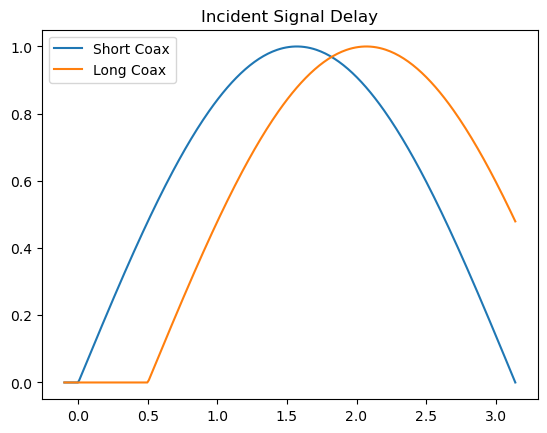

In [24]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.plot(sample_t, [max(long_amps[i], 0) for i in range(len(long_amps))], label="Long Coax")
plt.title("Incident Signal Delay")
plt.legend()
plt.show()

In [ ]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.title("Outgoing Signal")
plt.legend()
plt.show()